In [2]:
import requests
import re
import nltk
import random
import pandas as pd
import numpy as np

from nltk import FreqDist
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from bs4 import BeautifulSoup
from urllib import request
from url_config import *
from utilitools import *
from matplotlib import pyplot as plt

In [3]:
data = leer_paths('data')
scripts = leer_paths('recomendador')


In [ ]:

# Esta función carga el archivo .csv que se encuentra en la ruta path con el nombre csv_file como un dataframe
def leer_csv(path,csv_file):
    '''
    Inserta ruta de carpeta donde se encuentra el archivo y nombre de archivo para hacer lectura de archivo como DataFrame
    '''
    for file in os.listdir(path):
        file_path = os.path.join(path,file)

        if csv_file in file_path:
            df = pd.read_csv(file_path)
    return df

# Se crea una función que realiza limpieza a la columna nombre, a través de expresiones regulares
def limpieza_clientes(df_clientes):
    df_clientes['nombre'] = df_clientes['nombre'].str.lower()
    df_clientes['nombre'] = df_clientes['nombre'].str.replace(r'[^a-z 0-9]', '',regex=True)
    df_clientes['nombre'] = df_clientes['nombre'].str.replace(r' s$', '',regex=True)
    df_clientes['nombre'] = df_clientes['nombre'].str.replace(r' e$', '',regex=True)
    df_clientes['nombre'] = df_clientes['nombre'].str.replace(r' d$', '',regex=True)

    df_clientes['nombre'] = df_clientes['nombre'].str.replace('cia','compania')

    tipi = [
        'sas',
        'sa',
        's a',
        's a s',
        'ltda',
        'limited',
        'limitada',
        'limit',
        'limitad',
        'sca',
        's c a',
        'esp',
        'e s p',
        'inc',
        's en c',
        'ci',
        'c i',
        'ltd',
        ]

    regstr = ''

    for term in tipi:
        regstr+=r'\s' + term +r'\b' + '|'

    df_clientes['nombre'] = df_clientes['nombre'].str.replace(regstr,'',regex=True)
    df_clientes['nombre'].str.strip()
    
    df_clientes['desc_ciiu_division'] = df_clientes['desc_ciiu_division'].str.lower()
    df_clientes['desc_ciuu_grupo'] = df_clientes['desc_ciuu_grupo'].str.lower()
    df_clientes['desc_ciiuu_clase'] = df_clientes['desc_ciiuu_clase'].str.lower()
    df_clientes['subsec'] = df_clientes['subsec'].str.lower()

    return df_clientes


def limpieza_noticias(df_noticias):
    df_noticias['news_title'] = df_noticias['news_title'].str.lower()
    df_noticias['news_text_content'] = df_noticias['news_text_content'].str.lower()
    return df_noticias

df_clientes = leer_csv(data,'clientes.csv')
df_clientes = limpieza_clientes(df_clientes)

df_noticias = leer_csv(data,'noticias.csv')
df_noticias = limpieza_noticias(df_noticias)

df_cn = leer_csv(data,'clientes_noticias.csv')

df_cn = df_cn[['nit','news_id']]
df_noticias = df_noticias[['news_id','news_title','news_text_content']]
BD = df_cn.merge(df_noticias, on='news_id',how='left')
BD = BD.merge(df_clientes, on='nit',how='left')
BD.dropna(inplace=True)

BD = BD.astype(str)

BD.head(5)

In [67]:
BD2 = BD.copy()

BD2['cliente'] = 0
BD2['sector'] = 0
BD2['no_aplica'] = 0
BD2['participacion'] = ''


for index, row in BD2.iterrows():
    if(row['nombre'] in row['news_title']):
        BD2['cliente'][index] += 1
    elif(row['nombre'] in row['news_text_content']):
        BD2['cliente'][index] += 1

    if(row['subsec'] in row['news_title']):
        BD2['sector'][index] += 1
    elif(row['subsec'] in row['news_text_content']):
        BD2['sector'][index] += 1

    if(BD2['sector'][index]==0 & BD2['cliente'][index] == 0):
        BD2['no_aplica'][index] += 1
    
    if(BD2['cliente'][index]==1): BD2['participacion'][index]+='cliente'
    elif(BD2['sector'][index]==1): BD2['participacion'][index]+='sector'
    else: BD2['participacion'][index]+='no aplica'

BD2

C:\Users\pipek\AppData\Local\Temp\ipykernel_34596\1778934483.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BD2['no_aplica'][index] += 1
C:\Users\pipek\AppData\Local\Temp\ipykernel_34596\1778934483.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else: BD2['participacion'][index]+='no aplica'
C:\Users\pipek\AppData\Local\Temp\ipykernel_34596\1778934483.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BD2['sector'][index] 

,nit,news_id,news_title,news_text_content,nombre,desc_ciiu_division,desc_ciuu_grupo,desc_ciiuu_clase,subsec,cliente,sector,no_aplica,participacion
0,900378212,news10006,precio dolar hoy: la cotizacion de la divisa a...,"este martes, 2 de agosto, el dolar alcanzo un ...",banco w,"actividades de servicios financieros, excepto ...",intermediacion monetaria,bancos comerciales,bancos,0,0,1,no aplica
1,900378212,news10011,es cierto: el presidente gustavo petro quiere ...,no hay nada mas permanente que lo temporal y a...,banco w,"actividades de servicios financieros, excepto ...",intermediacion monetaria,bancos comerciales,bancos,0,1,0,sector
2,860034313,news10011,es cierto: el presidente gustavo petro quiere ...,no hay nada mas permanente que lo temporal y a...,banco davivienda,"actividades de servicios financieros, excepto ...",intermediacion monetaria,bancos comerciales,bancos,0,1,0,sector
3,900378212,news10015,gustavo petro: ?que dice el informe final de s...,el equipo de empalme del gobierno del presiden...,banco w,"actividades de servicios financieros, excepto ...",intermediacion monetaria,bancos comerciales,bancos,0,0,1,no aplica
4,900166896,news10015,gustavo petro: ?que dice el informe final de s...,el equipo de empalme del gobierno del presiden...,hino motors manufacturing colombia,"fabricacion de vehiculos automotores, remolque...",fabricacion de vehiculos automotores y sus mot...,fabricacion de vehiculos automotores y sus mot...,equipo de transporte,0,0,1,no aplica
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74704,800230209,news99997,en cucuta subio el desempleo en junio y fue de...,"este viernes, el departamento administrativo n...",weatherford colombia,actividades de servicios de apoyo para la expl...,actividades de apoyo para la extraccion de pet...,actividades de apoyo para la extraccion de pet...,extraccion de petroleo,0,0,1,no aplica
74705,890209174,news99997,en cucuta subio el desempleo en junio y fue de...,"este viernes, el departamento administrativo n...",ismocol,actividades de servicios de apoyo para la expl...,actividades de apoyo para la extraccion de pet...,actividades de apoyo para la extraccion de pet...,extraccion de petroleo,0,0,1,no aplica
74706,830069311,news99997,en cucuta subio el desempleo en junio y fue de...,"este viernes, el departamento administrativo n...",nabors drilling international bermuda,actividades de servicios de apoyo para la expl...,actividades de apoyo para la extraccion de pet...,actividades de apoyo para la extraccion de pet...,extraccion de petroleo,0,0,1,no aplica
74707,830130106,news99997,en cucuta subio el desempleo en junio y fue de...,"este viernes, el departamento administrativo n...",soenergy international colombia,actividades de servicios de apoyo para la expl...,actividades de apoyo para la extraccion de pet...,actividades de apoyo para la extraccion de pet...,gas,0,0,1,no aplica


In [70]:
df_participacion = BD2.copy()
df_participacion.to_csv(os.path.join(data,r'output/participacion.csv'),index=False)


In [88]:
df_categorizacion = pd.read_csv(os.path.join(data,r'output/categorizacion.csv'))
df_participacion = pd.read_csv(os.path.join(data,r'output/participacion.csv'))
df_categorizacion = df_categorizacion[['news_id','clase']]
#df_cat2 = df_participacion.drop(columns=['desc_ciiu_division','desc_ciuu_grupo','desc_ciiuu_clase','cliente','sector','no_aplica'])
df_cat2 = df_participacion.merge(df_categorizacion,on='news_id',how='left')
df_cat2['clase'] = np.where((df_cat2['clase'] == 'Otras') & (df_cat2['participacion'] == 'no aplica'),'Descartable',df_cat2['clase'])

In [31]:
#1. Aporte al conocimiento del cliente
#Sacar tokens de 
stops = stopwords.words('spanish')
regex = re.compile('[^a-zA-Z]')


def clean_tokens(token_list):
    token_list = sorted(set(token_list))
    filtered_tokens = [token for token in token_list if token not in stops]

    return filtered_tokens


def token_influence(tokens1,tokens2):
    freq_t2 = FreqDist(tokens2)
    count = 0
    for token in tokens1:
        count+=freq_t2[token]
    return count


def tokenize_df(df):
    df2 = pd.DataFrame()
    df2['client_strings'] = df[['desc_ciiu_division','desc_ciuu_grupo','desc_ciiuu_clase']].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)
    df2['client_strings'].str.lower()
    df2['client_strings'] = df2['client_strings'].str.replace(r'[^A-Za-z\s]+', '')
    
    df2['news_strings'] = df[['news_title','news_text_content']].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)
    df2['news_strings'].str.lower()
    df2['news_strings'] = df2['news_strings'].str.replace(r'[^A-Za-z\s]+', '')

    df2['tokens'] = df2.apply(lambda row: nltk.word_tokenize(row['client_strings']), axis=1)

    df['n_tokens'] = df2.apply(lambda row: nltk.word_tokenize(row['news_strings']), axis=1)
    df['client_tokens'] = df2['tokens'].apply(clean_tokens)



In [ ]:

tokenize_df(df_cat2)

df_cat2

In [94]:
def token_influence(tokens1,tokens2):
    freq_t2 = FreqDist(tokens2)
    count = 0
    for token in tokens1:
        count+=freq_t2[token]
    return count


df_cat2['influencia_cliente'] = df_cat2.apply(lambda x: token_influence(x.client_tokens,x.n_tokens),axis=1)
df_cat2['influencia_cliente'].describe()

count    74617.000000
mean         5.650120
std         42.389742
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max       1620.000000
Name: influencia_cliente, dtype: float64

In [98]:
df_cat2.to_csv(os.path.join(data,r'output/recomendacion.csv'),index=False)


In [4]:
df_rec = pd.read_csv(os.path.join(data,r'output/recomendacion.csv'))
df_rec

,nit,news_id,news_title,news_text_content,nombre,desc_ciiu_division,desc_ciuu_grupo,desc_ciiuu_clase,subsec,cliente,sector,no_aplica,participacion,clase,n_tokens,client_tokens,influencia_cliente
0,900378212,news10006,precio dolar hoy: la cotizacion de la divisa a...,"este martes, 2 de agosto, el dolar alcanzo un ...",banco w,"actividades de servicios financieros, excepto ...",intermediacion monetaria,bancos comerciales,bancos,0,0,1,no aplica,Macroeconomía,"['precio', 'dolar', 'hoy', 'la', 'cotizacion',...","['actividades', 'bancos', 'comerciales', 'exce...",0
1,900378212,news10011,es cierto: el presidente gustavo petro quiere ...,no hay nada mas permanente que lo temporal y a...,banco w,"actividades de servicios financieros, excepto ...",intermediacion monetaria,bancos comerciales,bancos,0,1,0,sector,Macroeconomía,"['es', 'cierto', 'el', 'presidente', 'gustavo'...","['actividades', 'bancos', 'comerciales', 'exce...",5
2,860034313,news10011,es cierto: el presidente gustavo petro quiere ...,no hay nada mas permanente que lo temporal y a...,banco davivienda,"actividades de servicios financieros, excepto ...",intermediacion monetaria,bancos comerciales,bancos,0,1,0,sector,Macroeconomía,"['es', 'cierto', 'el', 'presidente', 'gustavo'...","['actividades', 'bancos', 'comerciales', 'exce...",5
3,900378212,news10015,gustavo petro: ?que dice el informe final de s...,el equipo de empalme del gobierno del presiden...,banco w,"actividades de servicios financieros, excepto ...",intermediacion monetaria,bancos comerciales,bancos,0,0,1,no aplica,Macroeconomía,"['gustavo', 'petro', 'que', 'dice', 'el', 'inf...","['actividades', 'bancos', 'comerciales', 'exce...",0
4,900166896,news10015,gustavo petro: ?que dice el informe final de s...,el equipo de empalme del gobierno del presiden...,hino motors manufacturing colombia,"fabricacion de vehiculos automotores, remolque...",fabricacion de vehiculos automotores y sus mot...,fabricacion de vehiculos automotores y sus mot...,equipo de transporte,0,0,1,no aplica,Macroeconomía,"['gustavo', 'petro', 'que', 'dice', 'el', 'inf...","['automotores', 'fabricacion', 'motores', 'rem...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74612,800230209,news99997,en cucuta subio el desempleo en junio y fue de...,"este viernes, el departamento administrativo n...",weatherford colombia,actividades de servicios de apoyo para la expl...,actividades de apoyo para la extraccion de pet...,actividades de apoyo para la extraccion de pet...,extraccion de petroleo,0,0,1,no aplica,Macroeconomía,"['en', 'cucuta', 'subio', 'el', 'desempleo', '...","['actividades', 'apoyo', 'canteras', 'explotac...",1
74613,890209174,news99997,en cucuta subio el desempleo en junio y fue de...,"este viernes, el departamento administrativo n...",ismocol,actividades de servicios de apoyo para la expl...,actividades de apoyo para la extraccion de pet...,actividades de apoyo para la extraccion de pet...,extraccion de petroleo,0,0,1,no aplica,Macroeconomía,"['en', 'cucuta', 'subio', 'el', 'desempleo', '...","['actividades', 'apoyo', 'canteras', 'explotac...",1
74614,830069311,news99997,en cucuta subio el desempleo en junio y fue de...,"este viernes, el departamento administrativo n...",nabors drilling international bermuda,actividades de servicios de apoyo para la expl...,actividades de apoyo para la extraccion de pet...,actividades de apoyo para la extraccion de pet...,extraccion de petroleo,0,0,1,no aplica,Macroeconomía,"['en', 'cucuta', 'subio', 'el', 'desempleo', '...","['actividades', 'apoyo', 'canteras', 'explotac...",1
74615,830130106,news99997,en cucuta subio el desempleo en junio y fue de...,"este viernes, el departamento administrativo n...",soenergy international colombia,actividades de servicios de apoyo para la expl...,actividades de apoyo para la extraccion de pet...,actividades de apoyo para la extraccion de pet...,gas,0,0,1,no aplica,Macroeconomía,"['en', 'cucuta', 'subio', 'el', 'desempleo', '...","['actividad

In [7]:
def inf_score(value):
    score = 0
    if value>=5: score+=1
    if value>=10: score+=1

    return score

def client_score(value):
    if value == 1: return 2
    else: return 0

def sec_score(value):
    if value == 1: return 1
    else: return 0

def len_score(value):
    score = 0
    value = len(value)
    if value>=500: score+=1

    return score

df_rec['inf_score'] = df_rec['influencia_cliente'].apply(inf_score) 
df_rec['client_score'] = df_rec['cliente'].apply(client_score) 
df_rec['sec_score'] = df_rec['sector'].apply(sec_score)
df_rec['len_score'] = df_rec['n_tokens'].apply(len_score)

df_rec['score'] = df_rec['inf_score']+df_rec['client_score']+df_rec['sec_score']+df_rec['len_score']


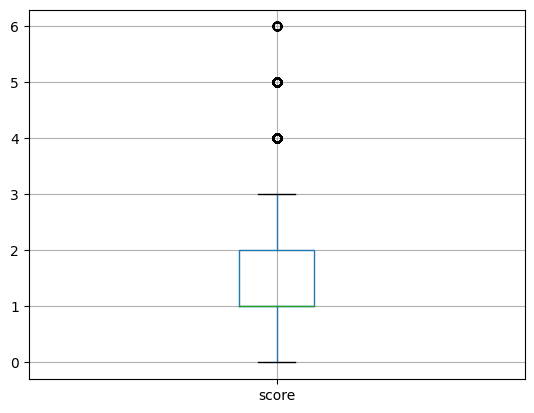

In [10]:
boxplot = df_rec.boxplot(column=['score'])

In [22]:
df_rec['dataton_equipo'] ='dataton_Siddhartha'
df_rec['categoria'] = df_rec['clase']

In [26]:
df_rec.sort_values(by=['nit','score'],ascending = [True,False],inplace=True,)
df_rec['recomendacion'] = 0

client_list = list(df_rec['nit'].unique())

for client in client_list:
    df_client = df_rec[df_rec['nit']==client]
    df_client['recomendacion'] = np.arange(1,len(df_client)+1)

    df_rec.update(df_client)

df_rec

C:\Users\pipek\AppData\Local\Temp\ipykernel_12660\2182749569.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_client['recomendacion'] = np.arange(1,len(df_client)+1)


,nit,news_id,news_title,news_text_content,nombre,desc_ciiu_division,desc_ciuu_grupo,desc_ciiuu_clase,subsec,cliente,...,client_tokens,influencia_cliente,inf_score,client_score,sec_score,len_score,score,dataton_equipo,categoria,recomendacion
64435,800000946.0,news97846,inauguran laboratorio quimico de investigacion...,"el ministro de justicia y del derecho, wilson ...",procter gamble colombia,fabricacion de sustancias y productos quimicos,fabricacion de otros productos quimicos,"fabricacion de jabones y detergentes, preparad...",manufactura de productos de tocador y articulo...,0.0,...,"['detergentes', 'fabricacion', 'jabones', 'lim...",11.0,2.0,0.0,0.0,1.0,3.0,dataton_Siddhartha,Macroeconomía,1.0
64474,800000946.0,news97853,inauguran laboratorio quimico de investigacion...,"el ministro de justicia, wilson ruiz orejuela,...",procter gamble colombia,fabricacion de sustancias y productos quimicos,fabricacion de otros productos quimicos,"fabricacion de jabones y detergentes, preparad...",manufactura de productos de tocador y articulo...,0.0,...,"['detergentes', 'fabricacion', 'jabones', 'lim...",11.0,2.0,0.0,0.0,1.0,3.0,dataton_Siddhartha,Macroeconomía,2.0
47172,800000946.0,news94698,bebidas organicas y veganas: novedades de expo...,tras dos anos de realizarse en formato virtual...,procter gamble colombia,fabricacion de sustancias y productos quimicos,fabricacion de otros productos quimicos,"fabricacion de jabones y detergentes, preparad...",manufactura de productos de tocador y articulo...,0.0,...,"['detergentes', 'fabricacion', 'jabones', 'lim...",5.0,1.0,0.0,0.0,1.0,2.0,dataton_Siddhartha,Macroeconomía,3.0
48436,800000946.0,news95244,oit lanza curso gratuito para prevenir acciden...,"lima - la oit, en el marco del proyecto del fo...",procter gamble colombia,fabricacion de sustancias y productos quimicos,fabricacion de otros productos quimicos,"fabricacion de jabones y detergentes, preparad...",manufactura de productos de tocador y articulo...,0.0,...,"['detergentes', 'fabricacion', 'jabones', 'lim...",7.0,1.0,0.0,0.0,1.0,2.0,dataton_Siddhartha,Innovación,4.0
63975,800000946.0,news97669,banco central: economia dominicana crecio un 5...,el indicador mensual de actividad economica (i...,procter gamble colombia,fabricacion de sustancias y productos quimicos,fabricacion de otros productos quimicos,"fabricacion de jabones y detergentes, preparad...",manufactura de productos de tocador y articulo...,0.0,...,"['detergentes', 'fabricacion', 'jabones', 'lim...",9.0,1.0,0.0,0.0,1.0,2.0,dataton_Siddhartha,Macroeconomía,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70375,901576411.0,news98704,?como avanza la reactivacion de la hoteleria e...,"el turismo, de manera constante, ha mostrado s...",mauria group,alojamiento,actividades de alojamiento de estancias cortas,alojamiento en apartahoteles,hoteles,0.0,...,"['actividades', 'alojamiento', 'apartahoteles'...",1.0,0.0,0.0,0.0,1.0,1.0,dataton_Siddhartha,Macroeconomía,37.0
70381,901576411.0,news98705,"violencia, racismo, inequidad y pobreza, algun...",santiago de cali se prepara para dos eventos d...,mauria group,alojamiento,actividades de alojamiento de estancias cortas,alojamiento en apartahoteles,hoteles,0.0,...,"['actividades', 'alojamiento', 'apartahoteles'...",0.0,0.0,0.0,0.0,1.0,1.0,dataton_Siddhartha,Macroeconomía,38.0
70387,901576411.0,news98708,colombia: petro asume el poder entre ilusion e...,gustavo petro se calzara el domingo la banda p...,mauria group,alojamiento,actividades de alojamiento de estancias cortas,alojamiento en apartahoteles,hoteles,0.0,...,"['actividades', 'alojamiento', 'apartahoteles'...",0.0,0.0,0.0,0.0,1.0,1.0,dataton_Siddhartha,Macroeconomía,39.0
27775,901576411.0,news49120,mas de 5.800 empleos directos se han generado ...,tu direccion de correo electronico no sera pub...,mauria group,alojamiento,actividades de alojamiento de estancias cortas,alojamiento en apartahoteles,hoteles,0.0,...,"['actividades', 'alojamiento'

In [31]:
df_final = df_rec[['dataton_equipo','nit','news_id','participacion','categoria','recomendacion']]
df_final.reset_index(drop=True,inplace=True)
df_final.head(30)

,dataton_equipo,nit,news_id,participacion,categoria,recomendacion
0,dataton_Siddhartha,800000946.0,news97846,no aplica,Macroeconomía,1.0
1,dataton_Siddhartha,800000946.0,news97853,no aplica,Macroeconomía,2.0
2,dataton_Siddhartha,800000946.0,news94698,no aplica,Macroeconomía,3.0
3,dataton_Siddhartha,800000946.0,news95244,no aplica,Innovación,4.0
4,dataton_Siddhartha,800000946.0,news97669,no aplica,Macroeconomía,5.0
5,dataton_Siddhartha,800000946.0,news97841,no aplica,Macroeconomía,6.0
6,dataton_Siddhartha,800000946.0,news97845,no aplica,Macroeconomía,7.0
7,dataton_Siddhartha,800000946.0,news97858,no aplica,Macroeconomía,8.0
8,dataton_Siddhartha,800000946.0,news12670,no aplica,Alianza,9.0
9,dataton_Siddhartha,800000946.0,news15986,no aplica,Macroeconomía,10.0


In [34]:
df_final.to_csv(os.path.join(data,r'output/recomendacion.csv'),index=False)

In [35]:
df_final = df_rec[['dataton_equipo','nit','news_id','participacion','categoria']]
df_final.to_csv(os.path.join(data,r'output/categorizacion.csv'),index=False)